In [36]:
import json
import pickle
import string

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

import torch
import torch.nn

from morpho_tagging.networks import *
from morpho_tagging.train import parser


In [21]:
device = "cpu"
load_params = parser.parse_args(["--training_type", "lm", "--data_path_ud", "dummy", "--save_dir", "dummy", "--pretrained_model", "/home/virginia/workspace/ContextualDecomposition-NLP/test_en_label/tagger_en_data_14_Nov_2021_19_24_11_best", "--pretrained_settings", "/home/virginia/workspace/ContextualDecomposition-NLP/test_en_label/tagger_en_settings_14_Nov_2021_19_24_11"])

with open(load_params.pretrained_settings) as settings_in:
    print("Loading model settings")
    settings_json = json.load(settings_in)
    for k in settings_json:
        if k != 'pretrained_model':
            setattr(load_params, k, settings_json[k])
        if k == "tagset_size":
            tagset_sizes = {}
            for a, v in settings_json[k].items():
                tagset_sizes[int(a)]=v
            setattr(load_params, k, tagset_sizes)
        
print(load_params)

model = Tagger(load_params, device)
model.load_state_dict(torch.load(load_params.pretrained_model))

Loading model settings
Namespace(batch_size=20, char_conv_act='relu', char_embedding_size=50, char_filter_sizes=[1, 2, 3, 4, 5, 6], char_gram=1, char_number_of_filters=[25, 50, 75, 100, 125, 150], char_rec_num_units=100, char_type='bilstm', char_vocab_size=40, data_path_ud='tests/tiny_test_data', dropout_frac=0.0, language='en', lm_hidden_size=100, lm_num_layers=1, lr=0.001, num_epochs=2, pad_index=0, pretrained_model='/home/virginia/workspace/ContextualDecomposition-NLP/test_en_label/tagger_en_data_14_Nov_2021_19_24_11_best', pretrained_settings='test_en/tagger_en_settings_14_Nov_2021_18_35_14', save_dir='test_en_label', save_file='tagger_en_', tagset_size={0: 14}, training_type='label', unique_words=0, word_vocab_size=64)


<All keys matched successfully>

In [22]:
# Get CharEmbeddings from model 
char_embedding_weights = model.char_embeddings.weight.detach().numpy()

In [23]:
char_pca = PCA(2)
char_pca_proj = char_pca.fit_transform(char_embedding_weights)
char_pca_proj[:5]

array([[-0.00321161,  0.00145275],
       [-0.00503654,  0.0016445 ],
       [ 0.00049552,  0.00490874],
       [ 0.02311566,  0.00391636],
       [ 0.01383496,  0.01039763]], dtype=float32)

In [24]:
tsne = TSNE(2)
char_tsne_proj = tsne.fit_transform(char_embedding_weights)
char_tsne_proj[:5]

/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([[  3.48455  ,  -7.7213497],
       [ 35.073177 ,   9.791849 ],
       [-30.24127  , -18.699621 ],
       [115.20636  , -16.685635 ],
       [ 35.417526 , -57.88024  ]], dtype=float32)

In [25]:
char_vocab_path = "/home/virginia/workspace/ContextualDecomposition-NLP/test_en_label/tagger_en_vocab_14_Nov_2021_19_24_11"

with open(char_vocab_path, 'rb') as vocab_in:
    char_vocab = pickle.load(vocab_in)

In [26]:
def get_char_class(char):
    """Returns 'digit', 'upper', 'lower', 'punct' or 'special' 
    """
    if char.isdigit():
        return 'digit'
    if char in string.punctuation:
        return 'punct'
    if char in ["<unk>", "<pad>", "<special_token>", "<eow>", "<sow>", "<eos>", "<sos>"]:
        return 'special'
    if char.isupper():
        return 'upper'
    if char.islower():
        return 'lower'

In [32]:
# build dataframe
entries = []
for k, char_idx in char_vocab[0].char_to_index.items():
    char_type = get_char_class(k)
    entries.append((k, char_idx, char_type, char_pca_proj[char_idx][0], char_pca_proj[char_idx][1], char_tsne_proj[char_idx][0], char_tsne_proj[char_idx][1]))

char_plot_df = pd.DataFrame.from_records(entries, columns=["char", "embedding_index", "char_class", "pca_x", "pca_y", "tsne_x", "tsne_y"])
        

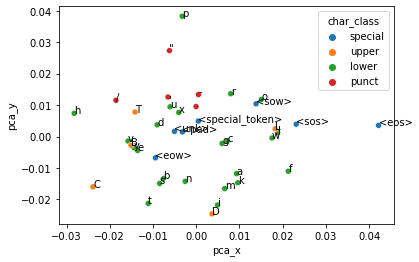

In [45]:
ax = sns.scatterplot(data = char_plot_df, x="pca_x", y="pca_y", hue="char_class")
for k, char_idx in char_vocab[0].char_to_index.items():
    ax.text(char_pca_proj[char_idx][0], char_pca_proj[char_idx][1], k)

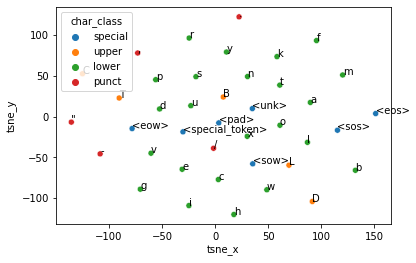

In [47]:
ax = sns.scatterplot(data = char_plot_df, x="tsne_x", y="tsne_y", hue="char_class")
for k, char_idx in char_vocab[0].char_to_index.items():
    ax.text(char_tsne_proj[char_idx][0], char_tsne_proj[char_idx][1], k)